# Geometric Brownian Motion Demo

Geometric Brownian motion  is a continuous stochastic process in which the natural logarithm of its values follows a Brownian motion. 

Mathematically, it can be defined as follows:

$S_t = S_0 e^{(\mu - \frac{\sigma^2}{2})t + \sigma W_t}$,

where $S_0$ is the initial value, $\mu$ and $\sigma$ are drift and difussion coefficients, respectively, and $W_t$ is a (standard) Brownian motion.

GBM is commonly used to model stock prices and options payoffs. 

In [1]:
import qmcpy as qp
import numpy as np
import scipy.stats as sc
import pandas as pd
import time
from matplotlib import pyplot
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display

# GMB object

In [2]:
gbm = qp.GeometricBrownianMotion(qp.Lattice(2)) 
gbm

GeometricBrownianMotion (TrueMeasure Object)
    time_vec        [0.5 1. ]
    drift           0
    diffusion       1
    mean            [-0.25 -0.5 ]
    covariance      [[0.5 0.5]
                    [0.5 1. ]]
    mean_gbm        [1. 1.]
    covariance_gbm  [[0.649 0.649]
                    [0.649 1.718]]
    decomp_type     PCA

In [3]:
gbm.gen_samples(n=4) # generates four 2-dimensional samples

array([[0.35876518, 0.09005443],
       [0.66707449, 0.75884888],
       [0.28231659, 0.5352634 ],
       [1.30038177, 1.29503024]])

# GMB vs Brownian motion

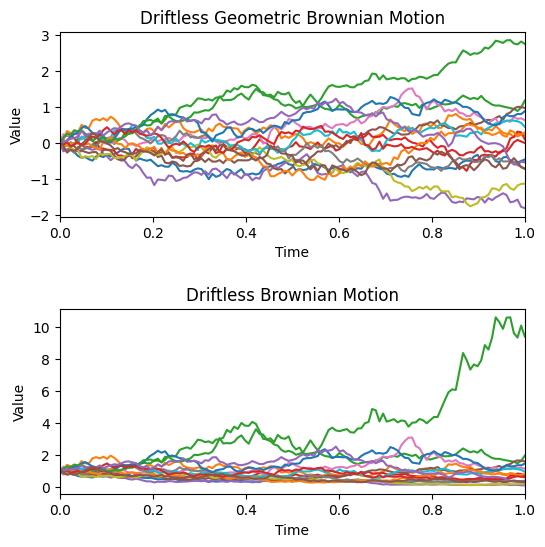

In [4]:
n = 16
discrete_distrib = qp.Lattice(2**7)
geometric_brownian_motions = {
     'Driftless Geometric Brownian Motion': qp.BrownianMotion(discrete_distrib),
     'Driftless Brownian Motion': qp.GeometricBrownianMotion(discrete_distrib)}
fig,ax = pyplot.subplots(nrows=len(geometric_brownian_motions),
                          ncols=1,figsize=(6,3*len(geometric_brownian_motions)))
ax = np.atleast_1d(ax)
for i,(name,gbm) in enumerate(geometric_brownian_motions.items()):
     t = gbm.gen_samples(n)
     t_w_init = np.hstack([gbm.initial_value*np.ones((n,1)),t])
     tvec_w_0 = np.hstack([0,gbm.time_vec])
     ax[i].plot(tvec_w_0,t_w_init.T)
     ax[i].set_xlim([tvec_w_0[0],tvec_w_0[-1]])
     ax[i].set_title(name)
     ax[i].set_xlabel('Time')  
     ax[i].set_ylabel('Value') 
plt.subplots_adjust(hspace=0.5)
plt.show();


# Generating and plotting GBM paths

In [5]:
def plot_gbm_paths(sampler, t_final, initial_value, drift, diffusion, n):
    
    gbm = qp.GeometricBrownianMotion(sampler, t_final, initial_value, drift, diffusion)
    t = gbm.gen_samples(n)
    
    initial_values = np.full((n, 1), gbm.initial_value)
    t_w_init = np.hstack((initial_values, t))
    tvec_w_0 = np.hstack(([0], gbm.time_vec))

    plt.figure(figsize=(7, 4))
    plt.plot(tvec_w_0, t_w_init.T) 
    plt.title(f'Realizations of Geometric Brownian Motion using {type(sampler).__name__} points')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.xlim([tvec_w_0[0], tvec_w_0[-1]])
    plt.show()

# 

# GBM using Standard Uniform Distribution 

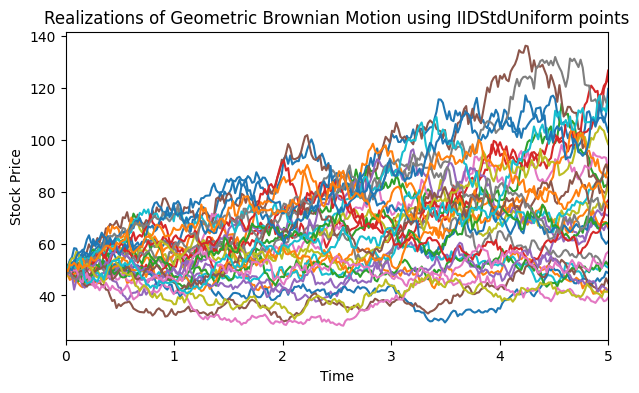

In [6]:
gbm_iid = plot_gbm_paths(qp.IIDStdUniform(2**8), t_final=5, initial_value=50, drift=0.1, diffusion=0.2, n=32)

# GBM using low-discrepancy Lattice sequence distrubtion 

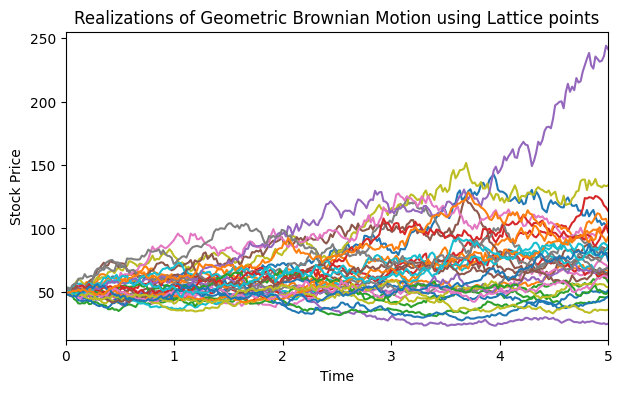

In [7]:
gbm_lattice = plot_gbm_paths(qp.Lattice(2**8), t_final=5, initial_value=50, drift=0.1, diffusion=0.2, n=32)

In [8]:
def plot_gbm(N, gbm, gbm_path):
    # Plot Brownian motion paths
    fig, ax = plt.subplots(figsize=(14, 7))
    for i in range(N):
        ax.plot(gbm.time_vec, gbm_path[i], lw=0.75, alpha=0.7, color='skyblue')

    T = max(gbm.time_vec)
    ax.set_title(f'Geometric Brownian Motion Paths\n{N} Simulations, T = {T}')
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$X(t)$')
    ax.set_ylim(bottom=0)  # Set y-axis to start from 0
    ax.set_xlim(0, T)  # Set x-axis limits to [0, T]

    # Add the horizontal histogram on the right
    final_values = gbm_path[:, -1]
    hist_ax = ax.inset_axes([1.05, 0., 0.5, 1])
    
    # Plot histogram
    hist_ax.hist(final_values, bins=10, density=True, alpha=0.5, 
                 color='skyblue', orientation='horizontal')
    
    # Calculate lognormal distribution parameters
    shape, loc, scale = sc.lognorm.fit(final_values, floc=0)
    
    # Generate x values for PDF
    x = np.linspace(0, max(final_values), 1000)
    
    # Generate the lognormal PDF
    pdf = sc.lognorm.pdf(x, shape, loc, scale)
    
    # Plot the theoretical lognormal PDF
    hist_ax.plot(pdf, x, 'r-', lw=2, label='Lognormal PDF')
    
    # Annotations
    hist_ax.axhline(np.mean(final_values), color='blue', linestyle='--', lw=1.5, label=r'$E[X_T]$')
    hist_ax.set_yticks([])  # Remove y-axis ticks for the histogram
    hist_ax.set_xlabel('Density')
    hist_ax.legend()
    hist_ax.set_ylim(bottom=0)  # Set y-axis to start from 0 for the histogram

    # Main plot legend
    plt.tight_layout()
    plt.show()

In [9]:
eps = np.finfo(float).eps
slider_style = {'handle_color': 'blue'}

@widgets.interact
def f(n=widgets.IntSlider(min=0, max=11, step=1, value=10, style=slider_style),
      t_final=widgets.FloatSlider(min=eps, max=10, step=0.1, value=10, style=slider_style),
      initial_value=widgets.FloatSlider(min=eps, max=100, step=0.1, value=40, style=slider_style),
      drift=widgets.FloatSlider(min=-2, max=2, step=0.1, value=0.1, style=slider_style),
      diffusion=widgets.FloatSlider(min=eps, max=4, step=0.1, value=0.2, style=slider_style)):
    
    gbm = qp.GeometricBrownianMotion(qp.Lattice(2**n, seed=7), t_final=t_final, initial_value=initial_value, drift=drift, diffusion=diffusion)
    gbm_path = gbm.gen_samples(2**n)
    plot_gbm(n, gbm, gbm_path)

interactive(children=(IntSlider(value=10, description='n', max=11, style=SliderStyle(handle_color='blue')), Fl…